**About :** Trains XGBoost models.

**TODO**:
- not leaky matrices

In [1]:
cd ../src

/workspace/kaggle_otto_rs/src


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import gc
import cudf
import json
import glob
import numba
import xgboost
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from data.fe import load_sessions

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
warnings.simplefilter(action="ignore", category=FutureWarning)

In [4]:
from params import *

from data.candidates import load_parquets
from model_zoo import TRAIN_FCTS

from utils.metrics import get_coverage
from utils.plot import plot_importances

### Load

In [5]:
import cudf

def load_parquets_cudf(regex):
    dfs = []
    for e, chunk_file in tqdm(enumerate(glob.glob(regex))):
        chunk = cudf.read_parquet(chunk_file)
        dfs.append(chunk)
    return cudf.concat(dfs).reset_index(drop=True)

In [6]:
import pandas as pd

def load_parquets_pd(regex):
    dfs = []
    df = None
    for e, chunk_file in tqdm(enumerate(glob.glob(regex))):
        if df is None:
            df = pd.read_parquet(chunk_file)
        else:
            df.append(pd.read_parquet(chunk_file), ignore_index=True)
    return df

In [7]:
VERSION = "v3"

In [8]:
# if VERSION == "v1":
#     df_train = pd.read_parquet(f'../output/fts_train_{VERSION}.parquet')
#     df_val = pd.read_parquet(f'../output/fts_val_{VERSION}.parquet')
# else:
#     df_val = load_parquets(f"../output/fts_val_{VERSION}/*")
#     df_train = load_parquets(f"../output/fts_train_{VERSION}/*")

#### Train data

In [9]:
POS_RATIO = 0.1
TARGET = "gt_orders"   # "gt_carts", "gt_clicks", "gt_orders"

In [10]:
df_train = load_parquets_cudf(f"../output/fts_train_{VERSION}/*")

if POS_RATIO:
    n_neg = int(df_train[TARGET].sum() / POS_RATIO)
    pos = df_train.index[df_train[TARGET] == 1]
    neg = df_train[[TARGET]][df_train[TARGET] == 0].sample(n_neg).index
    df_train = df_train.iloc[cudf.concat([pos, neg])]

25it [00:05,  4.53it/s]


In [11]:
df_val_c = load_parquets_cudf(f"../output/fts_val_c_{VERSION}/*")

if POS_RATIO:
    n_neg = int(df_val_c[TARGET].sum() / POS_RATIO)
    pos = df_val_c.index[df_val_c[TARGET] == 1]
    neg = df_val_c[[TARGET]][df_val_c[TARGET] == 0].sample(n_neg).index
    df_val_c = df_val_c.iloc[cudf.concat([pos, neg])]

19it [00:02,  7.65it/s]


In [12]:
df_train = cudf.concat([df_train, df_val_c], ignore_index=True)

del df_val_c
numba.cuda.current_context().deallocations.clear()
gc.collect()

250

In [13]:
# df_train = df_train.to_pandas()

#### Val data

In [14]:
df_val = load_parquets_cudf(f"../output/fts_val_{VERSION}/*")
df_val = df_val.sort_values(['session', 'candidates'])

19it [00:04,  4.68it/s]


In [15]:
# %%time
# df_val = pd.read_csv(f'../output/fts_train_{VERSION}.csv', nrows=10_000_000)

In [16]:
# for c in df_train.columns[5:]:
#     plt.figure(figsize=(10, 4))
#     sns.kdeplot(df_train.head(10000)[c].values, label="train")
#     sns.kdeplot(df_val.head(10000)[c].values, label="val")
#     plt.legend()
#     plt.title(c)
#     plt.show()
#     break

In [17]:
# import optuna
import cuml
from sklearn.metrics import roc_auc_score
from numerize.numerize import numerize
from utils.torch import seed_everything


def train(df_train, df_val, config, log_folder=None, optimize=False):
    seed_everything(config.seed)

    txt = f"{'Optimizing' if optimize else 'Training'} {config.model.upper()} Model"
    print(f"\n-------------   {txt}   -------------\n")

#     if config.pos_ratio:
#         n_neg = int(df_train[config.target].sum() / config.pos_ratio)
#         pos = df_train.index[df_train[config.target] == 1]
#         neg = df_train[[config.target]][df_train[config.target] == 0].sample(n_neg).index
#         df_train = df_train.iloc[cudf.concat([pos, neg])]

    if optimize:  # TODO
        study = optuna.create_study(direction="minimize")
        objective = lambda x: objective_xgb(x, df_train, df_val, features, target)
        study.optimize(objective, n_trials=50)
        print(study.best_params)
        return study.best_params

    train_fct = TRAIN_FCTS[config.model]

    print(f"    -> {numerize(len(df_train))} training candidates")
    print(f"    -> {numerize(len(df_val))} validation candidates\n")
    
    pred_val, model = train_fct(
        df_train,
        df_val,
        features=config.features,
        target=config.target,
        params=config.params,
        n_candidates_es=config.n_candidates_es,
    )
    
    # Score
    try:
        auc = roc_auc_score(df_val[config.target], pred_val)
    except:
        auc = cuml.metrics.roc_auc_score(df_val[config.target].astype('int32'), pred_val)
    
    print(f'\n -> AUC : {auc:.4f}\n')

    # Feature importance
    if config.model == "xgb":
        ft_imp = model.get_score()
    else:
        ft_imp = model.feature_importances_  # TODO
    try:
        ft_imp = pd.DataFrame(
            pd.Series(ft_imp, index=config.features), columns=["importance"]
        )
    except:
        ft_imp = None
  
    if log_folder is None:
        return pred_val, ft_imp, model

    # Save stuff
    if config.model == "xgb":
        model.save_model(log_folder + f"{config.model}_{fold}.json")
    elif config.model == "lgbm":
        try:
            model.booster_.save_model(log_folder + f"{config.model}_{fold}.txt")
        except Exception:
            model.save_model(log_folder + f"{config.model}_{fold}.txt")
    else:   # catboost, verif
        model.save_model(log_folder + f"{config.model}_{fold}.txt")

    ft_imp.to_csv(log_folder + "ft_imp.csv")
    np.save(log_folder + "pred_oof.npy", pred_oof)
    
    return pred_val, ft_imp, model

### Params

In [18]:
PARAMS = {
    "xgb":
    {
        "learning_rate": 0.01,
        'max_depth': 10,
        "subsample": 0.25,
        'colsample_bytree': 0.9,
        'reg_alpha': 0.1,
        'reg_lambda': 1,
        "min_child_weight": 0.01,
#         "gamma": 0.01,
        'eval_metric':'auc',  # map
        'objective':'binary:logistic',  # 'rank:pairwise',
        'tree_method':'gpu_hist',
        'predictor':'gpu_predictor',
    },
    "catboost":
        {
        'depth': 12,
        "l2_leaf_reg": 0.1,
        "min_data_in_leaf": 2000,
        'reg_lambda': 0.1,
        "model_size_reg": 0.5,
        "border_count": 256,
        },
    "lgbm": {
        "learning_rate": 0.05,
        "num_leaves": 511,
        "colsample_bytree": 0.5,
        "reg_alpha": 1,
        "reg_lambda": 70,
        "min_child_samples": 2000,  # MODIF  # 2000
        "min_split_gain": 0.02,
        "min_child_weight": 0.03,
        "path_smooth": 0.2,
#             "min_data_in_bin": 32,
    }
}

In [19]:
df_train.columns

Index(['session', 'candidates', 'gt_clicks', 'gt_carts', 'gt_orders',
       'logspace_w', 'linspace_w', 'matrix_123_temporal_20_mean',
       'matrix_123_temporal_20_sum', 'matrix_123_temporal_20_max',
       'matrix_123_temporal_20_logspace_mean',
       'matrix_123_temporal_20_logspace_sum',
       'matrix_123_temporal_20_logspace_max',
       'matrix_123_temporal_20_linspace_mean',
       'matrix_123_temporal_20_linspace_sum',
       'matrix_123_temporal_20_linspace_max', 'matrix_123_type136_20_mean',
       'matrix_123_type136_20_sum', 'matrix_123_type136_20_max',
       'matrix_123_type136_20_logspace_mean',
       'matrix_123_type136_20_logspace_sum',
       'matrix_123_type136_20_logspace_max',
       'matrix_123_type136_20_linspace_mean',
       'matrix_123_type136_20_linspace_sum',
       'matrix_123_type136_20_linspace_max', 'matrix_12__20_mean',
       'matrix_12__20_sum', 'matrix_12__20_max', 'matrix_12__20_logspace_mean',
       'matrix_12__20_logspace_sum', 'matrix_12__2

In [29]:
class Config:
    seed = 100
    version = VERSION

    features = [
        'logspace_w', 'linspace_w',
#         'matrix_123_temporal_20_mean', 'matrix_123_temporal_20_sum', 'matrix_123_temporal_20_max',
#         'matrix_123_temporal_20_logspace_mean', 'matrix_123_temporal_20_logspace_sum', 'matrix_123_temporal_20_logspace_max',
#         'matrix_123_temporal_20_linspace_mean', 'matrix_123_temporal_20_linspace_sum', 'matrix_123_temporal_20_linspace_max',
#         'matrix_123_type136_20_mean', 'matrix_123_type136_20_sum', 'matrix_123_type136_20_max',
#         'matrix_123_type136_20_logspace_mean', 'matrix_123_type136_20_logspace_sum', 'matrix_123_type136_20_logspace_max',
#         'matrix_123_type136_20_linspace_mean', 'matrix_123_type136_20_linspace_sum', 'matrix_123_type136_20_linspace_max',
#         'matrix_12__20_mean', 'matrix_12__20_sum', 'matrix_12__20_max',
#         'matrix_12__20_logspace_mean', 'matrix_12__20_logspace_sum', 'matrix_12__20_logspace_max',
#         'matrix_12__20_linspace_mean', 'matrix_12__20_linspace_sum', 'matrix_12__20_linspace_max',
        'clicks_popularity', 'carts_popularity', 'orders_popularity',
#         'candidate_clicks_before',
#         'candidate_carts_before',
#         'candidate_orders_before',
#         'candidate_*_before',
        'n_views', 'n_clicks', 'n_carts', 'n_orders'
    ]

    cat_features = []

    target = TARGET  # "gt_orders", "gt_clicks", "gt_orders"
    pos_ratio = POS_RATIO
    model = "xgb"

    params = PARAMS[model]
    n_candidates_es = 10_000_000

    use_es = True

### Main

In [30]:
OPTIMIZE = False
TRAIN = True
DEBUG = True

#### Optimize

In [31]:
Config.params

{'learning_rate': 0.01,
 'max_depth': 10,
 'subsample': 0.25,
 'colsample_bytree': 0.9,
 'reg_alpha': 0.1,
 'reg_lambda': 1,
 'min_child_weight': 0.01,
 'eval_metric': 'auc',
 'objective': 'binary:logistic',
 'tree_method': 'gpu_hist',
 'predictor': 'gpu_predictor'}

#### Train

In [32]:
%%time

# if TRAIN:
log_folder = None
if not DEBUG:
    log_folder = prepare_log_folder(LOG_PATH + f"lvl_{LEVEL}/")
    print(f'Logging results to {log_folder}')
    save_config(Config, log_folder + 'config')
    create_logger(directory=log_folder, name="logs.txt")

pred_val, ft_imp, model = train(df_train, df_val, Config, log_folder=log_folder)


-------------   Training XGB Model   -------------

    -> 3.81M training candidates
    -> 49.53M validation candidates

[0]	val-auc:0.93741
[100]	val-auc:0.94307
[200]	val-auc:0.94380
[300]	val-auc:0.94415
[400]	val-auc:0.94445
[500]	val-auc:0.94461
[600]	val-auc:0.94466
[700]	val-auc:0.94467
[785]	val-auc:0.94465


19it [00:19,  1.04s/it]



 -> AUC : 0.9477

CPU times: user 1min 9s, sys: 995 ms, total: 1min 10s
Wall time: 1min 9s


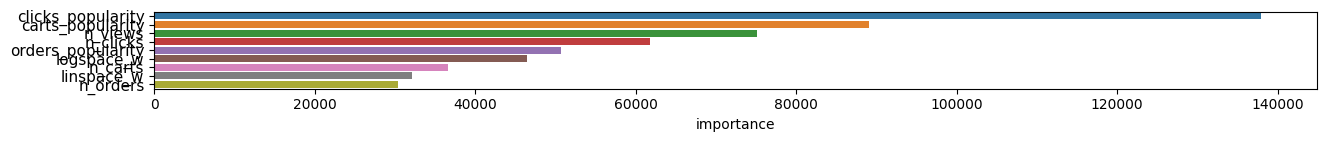

In [33]:
plot_importances(ft_imp)

### Eval

In [34]:
gt = pd.read_parquet("../output/val_labels.parquet")

In [35]:
# preds = cudf.from_pandas(df_val)

preds = df_val[['session', 'candidates']]
preds['pred'] = pred_val

preds = preds.sort_values(['session', 'pred'], ascending=[True, False])
preds = preds[['session', 'candidates', 'pred']].groupby('session').agg(list).reset_index()

preds = preds.to_pandas()
preds['candidates'] = preds['candidates'].apply(lambda x: x[:20])

In [36]:
dfs = load_sessions("../output/val_parquet/*")

if Config.target == "gt_carts":
    top = dfs.loc[dfs["type"] == 1, "aid"].value_counts().index.values[:20].tolist()
elif Config.target == "gt_orders":
    top = dfs.loc[dfs["type"] == 2, "aid"].value_counts().index.values[:20].tolist()
else:
    top = dfs.loc[dfs["type"] == 0, "aid"].value_counts().index.values[:20].tolist()

preds['candidates'] = preds['candidates'].apply(lambda x: list(x) + top[: 20 - len(x)])

del dfs
numba.cuda.current_context().deallocations.clear()
gc.collect()

35

In [37]:
recalls = []
for col in CLASSES:
    if "gt_" + col not in [Config.target]:
        continue

    if f"gt_{col}" not in preds.columns:
        preds = preds.merge(gt[gt["type"] == col].drop("type", axis=1), how="left").rename(
            columns={"ground_truth": f"gt_{col}"}
        )

    n_preds, n_gts, n_found = get_coverage(
        preds["candidates"].values, preds[f"gt_{col}"].values
    )

    print(
        f"{col}\t-  Found {numerize(n_found)} GTs\t-  Recall : {n_found / n_gts :.4f}"
    )
    recalls.append(n_found / n_gts)

orders	-  Found 200.27K GTs	-  Recall : 0.6394


- carts	-  Found 229.03K GTs	-  Recall : 0.3976
- carts	-  Found 229.03K GTs	-  Recall : 0.6394

- clicks	-  Found 877.27K GTs	-  Recall : 0.4997
- carts	-  Found 229.36K GTs	-  Recall : 0.3979
- orders	-  Found 201.71K GTs	-  Recall : 0.6438

To beat :
- clicks recall = 0.5256
- carts recall = 0.4093
- orders recall = 0.6488

Done